# Installation

In [ ]:
#Installs HuggingFace datasets
%pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [ ]:
#Mount Google Drive to import preset images used in later image comparisons
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Create and train CAE

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# Define input shape, SIZE is 400 can be found in the Dataset pipeline
# Creates an input shape of (400,400,1) i.e. a 400x400 pixel image with 1 colour channel - Greyscale
input = layers.Input(shape=(SIZE, SIZE, 1))

# Encoder - Reduces Dimensionality of Input

# Creates a Convolutional 2D layer with a filter size of 200, a 3x3 kernel, utilises the relu activation function with a padding of same to retain image dimensions
# A filter size of 200 is as large as this layer can have without running out of memory, all other parameters gave worse results when changed
x = layers.Conv2D(200, (3, 3), activation="relu", padding="same")(input)
# Creates a 2DMaxPooling layer with a kernel size of 2x2 which halves the input shape
x = layers.MaxPooling2D((2, 2), padding="same")(x)
# A filter size of 100 is as large as this layer can have without running out of memory
x = layers.Conv2D(100, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder - Reconstructs Input using data from the bottleneck

# Creates a Convolutional 2D Transpose layer with a filter size of 200, a 3x3 kernel, utilises the relu activation function with a padding of same to retain image dimensions
# A filter size of 200 is as large as this layer can have without running out of memory, all other parameters gave worse results when changed
x = layers.Conv2DTranspose(200, (3, 3), strides=2, activation="relu", padding="same")(x)
# A filter size of 100 is as large as this layer can have without running out of memory
x = layers.Conv2DTranspose(100, (3, 3), strides=2, activation="relu", padding="same")(x)
# Creates a Convolutional 2D layer with a filter size of 1, a 3x3 kernel, utilises the sigmoid activation function with a padding of same to retain image dimensions
# Used to reshape input to match its initial shape
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Compile Model
model = Model(input, x)
# Compile using the adam optimiser, showcased the best results and using the binary crossentropy loss value due to the image being greyscale
model.compile(optimizer="adam", loss="binary_crossentropy")
# Prints the summary of the models layers
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 400, 400, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 400, 400, 200)  │         2,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 200, 200, 200)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 200, 200, 100)  │       180,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 100, 100, 100)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 200, 200, 200)  │       180,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 400, 400, 100)  │       180,100 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 400, 400, 1)    │           901 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 543,301 (2.07 MB)

 Trainable params: 543,301 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model with the input being the noisy images and the target being the original image
# CAE models require a large number of epochs therefore 50 or 100 is required
# The "Receipts_even_more dataset" has enough RAM headroom for a batch size of 32 however if using the combined dataset(s) then it must be lowered to 8
# The validation data is the test split and is used to adjust weights during traing and prevent overfitting
# Shuffle simple shuffles the datasets after every epoch
model.fit(noisy_train_images,train_images, epochs=50, batch_size=8,
          shuffle=True, validation_data=(noisy_test_images, test_images))

# Save CAE

In [ ]:
model.save("Iteration950EpochsTest2.keras")

# Image Comparison

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
image = Image.open('/content/drive/My Drive/ReceiptImages/NoisyReceipts/1001-receipt.jpg').convert('L')
image = image.resize((SIZE,SIZE), Resampling.LANCZOS)
image = np.array(image)
image = image.reshape(1, SIZE, SIZE, 1)
image = image.astype('float32') / 255.
print(image.shape)

(1, 400, 400, 1)


In [ ]:
reconstructed_image = model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


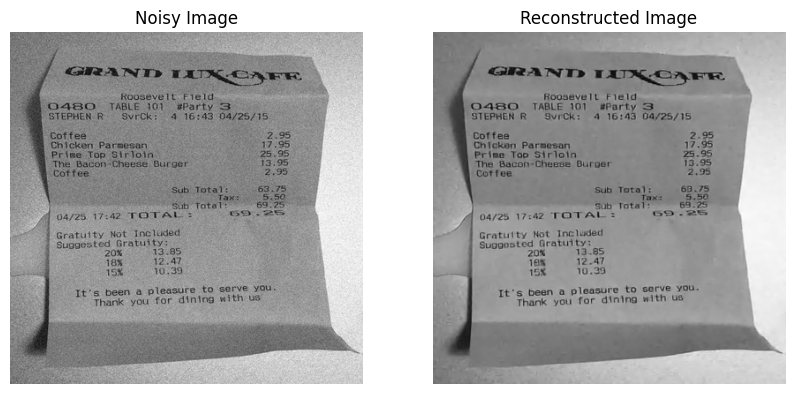

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1).set_title('Noisy Image')
plt.imshow(image.reshape(SIZE, SIZE), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2).set_title('Reconstructed Image')
plt.imshow(reconstructed_image.reshape(SIZE, SIZE), cmap='gray')
plt.axis('off')

plt.show()

In [ ]:
image2 = Image.open('/content/drive/My Drive/ReceiptImages/NoisyReceipts/1000-receipt.jpg').convert('L')
image2 = image2.resize((SIZE,SIZE), Resampling.LANCZOS)
image2 = np.array(image2)
image2 = image2.reshape(1, SIZE, SIZE, 1)
image2 = image2.astype('float32') / 255.
print(image2.shape)

(1, 400, 400, 1)


In [ ]:
reconstructed_image2 = model.predict(image2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


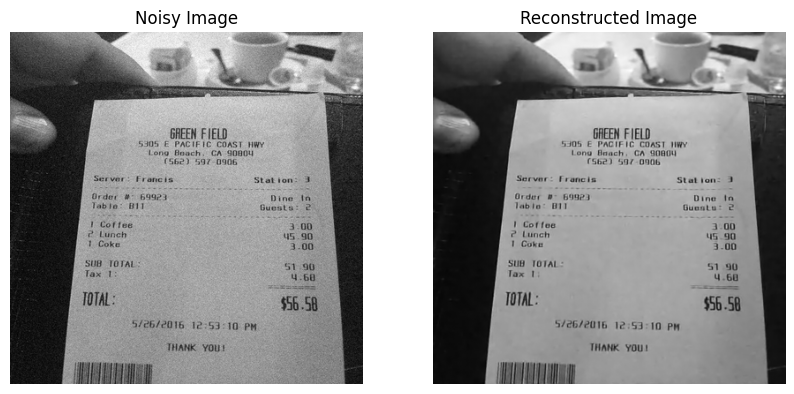

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1).set_title('Noisy Image')
plt.imshow(image2.reshape(SIZE, SIZE), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2).set_title('Reconstructed Image')
plt.imshow(reconstructed_image2.reshape(SIZE, SIZE), cmap='gray')
plt.axis('off')

plt.show()

In [ ]:
image3 = Image.open('/content/drive/My Drive/ReceiptImages/NoisyReceipts/1005-receipt.jpg').convert('L')
image3 = image3.resize((SIZE,SIZE), Resampling.LANCZOS)
image3= np.array(image3)
image3 = image3.reshape(1, SIZE, SIZE, 1)
image3 = image3.astype('float32') / 255.
print(image3.shape)

(1, 400, 400, 1)


In [ ]:
reconstructed_image3 = model.predict(image3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


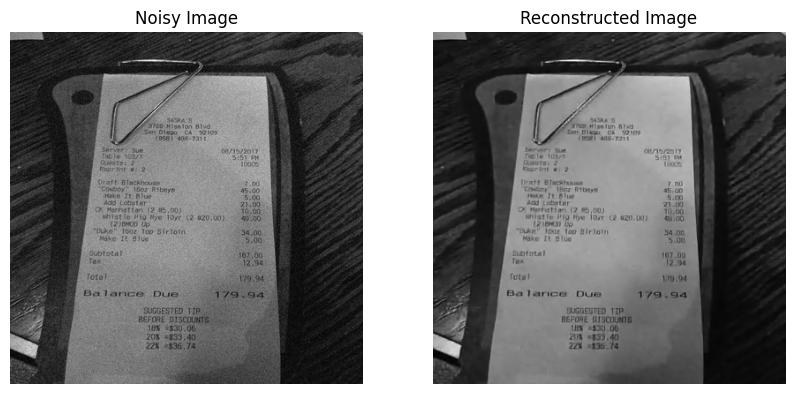

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1).set_title('Noisy Image')
plt.imshow(image3.reshape(SIZE, SIZE), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2).set_title('Reconstructed Image')
plt.imshow(reconstructed_image3.reshape(SIZE, SIZE), cmap='gray')
plt.axis('off')

plt.show()

# Receipts Even More Dataset Pipeline

## Import Dataset

In [ ]:
#Load the dataset and store each split in a different variable
from datasets import load_dataset
train = load_dataset("amaye15/receipts_even_more", split="train")
test = load_dataset("amaye15/receipts_even_more", split="test")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/611 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/102M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11798 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2360 [00:00<?, ? examples/s]

## Preprocess Dataset

### Resize dataset and convert to greyscale

In [ ]:
import numpy as np
from PIL import Image
from PIL.Image import Resampling

IMG_SIZE = (400, 400)
SIZE = 400
train_images = []
test_images = []

#Iterate over each row in both splits
for(i, image) in enumerate(train):
    #Extract the image data contained the the pixel_values column, resize it using the LANCZOS algorithm, and convert it to greyscale
    img = image["pixel_values"].resize(IMG_SIZE, Resampling.LANCZOS).convert('L')
    train_images.append(img)

for(i, image) in enumerate(test):
    img = image["pixel_values"].resize(IMG_SIZE, Resampling.LANCZOS).convert('L')
    test_images.append(img)

#Convert both arrays to NumPy arrays
train_images = np.array(train_images)
test_images = np.array(test_images)


### Normalise dataset pixel values

In [ ]:
#Convert NumPy arrays to float32 and normalise pixel values
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

### Create Noisy images

In [ ]:
import skimage as ski

noisy_train_images = []
noisy_test_images = []

#Iterate over the image NumPy arrays
for image in train_images:
    #Add noise to images
    noisy_train_images.append(ski.util.random_noise(image, mode='gaussian', var=0.001))
#Save noisy images in their own NumPy array
noisy_train_images = np.array(noisy_train_images)

for image in test_images:
    noisy_test_images.append(ski.util.random_noise(image, mode='gaussian', var=0.001))
noisy_test_images = np.array(noisy_test_images)

print(noisy_train_images.shape)
print(noisy_test_images.shape)

(11798, 400, 400)
(2360, 400, 400)


# Receipts Even More + Invoices and Receipts OCR Dataset Pipeline

## Import Dataset

In [ ]:
#Load the dataset and store each split in a different variable
from datasets import load_dataset

train = load_dataset("amaye15/receipts_even_more", split="train")
test = load_dataset("amaye15/receipts_even_more", split="test")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/611 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/102M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11798 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2360 [00:00<?, ? examples/s]

In [ ]:
#Load the dataset and store each split in a different variable
train2 = load_dataset("mychen76/invoices-and-receipts_ocr_v2", split="train")
test2 = load_dataset("mychen76/invoices-and-receipts_ocr_v2", split="test")

README.md:   0%|          | 0.00/912 [00:00<?, ?B/s]

(…)-00000-of-00002-801e1aea0f0adc30.parquet:   0%|          | 0.00/233M [00:00<?, ?B/s]

(…)-00001-of-00002-2e5ab49d1f705bff.parquet:   0%|          | 0.00/134M [00:00<?, ?B/s]

(…)-00000-of-00001-5e49167f3ab7fa83.parquet:   0%|          | 0.00/33.8M [00:00<?, ?B/s]

(…)-00000-of-00001-a34ca26ac5064310.parquet:   0%|          | 0.00/29.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2843 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/225 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/170 [00:00<?, ? examples/s]

## Preprocess Dataset

In [ ]:
import numpy as np
from PIL import Image
from PIL.Image import Resampling

IMG_SIZE = (400, 400)
SIZE = 400
train_images = []
test_images = []
#Iterate over each row in all splits
for(i, image) in enumerate(train):
    #Extract the image data contained the the pixel_values column, resize it using the LANCZOS algorithm, and convert it to greyscale
    img = image["pixel_values"].resize(IMG_SIZE, Resampling.LANCZOS).convert('L')
    train_images.append(img)

for(i, image) in enumerate(train2):
    #Extract the image data contained the the image column, resize it using the LANCZOS algorithm, and convert it to greyscale
    img = image["image"].resize(IMG_SIZE, Resampling.LANCZOS).convert('L')
    train_images.append(img)

for(i, image) in enumerate(test):
    img = image["pixel_values"].resize(IMG_SIZE, Resampling.LANCZOS).convert('L')
    test_images.append(img)

for(i, image) in enumerate(test2):
    img = image["image"].resize(IMG_SIZE, Resampling.LANCZOS).convert('L')
    test_images.append(img)

#Convert both arrays to NumPy arrays
train_images = np.array(train_images)
test_images = np.array(test_images)

In [ ]:
#Convert NumPy arrays to float32 and normalise pixel values
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

In [ ]:
import skimage as ski

noisy_train_images = []
noisy_test_images = []

#Iterate over the image NumPy arrays
for image in train_images:
    #Add noise to images
    noisy_train_images.append(ski.util.random_noise(image, mode='gaussian', var=0.001))
#Save noisy images in their own NumPy array
noisy_train_images = np.array(noisy_train_images)

for image in test_images:
    noisy_test_images.append(ski.util.random_noise(image, mode='gaussian', var=0.001))
noisy_test_images = np.array(noisy_test_images)

print(noisy_train_images.shape)
print(noisy_test_images.shape)

(14641, 400, 400)
(2585, 400, 400)


# Receipts + Invoices and Receipts OCR Dataset Pipeline


From testing results this pipeline trains poorer performing models when compared to the two above.

## Import Dataset

In [ ]:
#Load the dataset and store each split in a different variable
from datasets import load_dataset

train = load_dataset("mychen76/invoices-and-receipts_ocr_v2", split="train")
test = load_dataset("mychen76/invoices-and-receipts_ocr_v2", split="test")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/912 [00:00<?, ?B/s]

(…)-00000-of-00002-801e1aea0f0adc30.parquet:   0%|          | 0.00/233M [00:00<?, ?B/s]

(…)-00001-of-00002-2e5ab49d1f705bff.parquet:   0%|          | 0.00/134M [00:00<?, ?B/s]

(…)-00000-of-00001-5e49167f3ab7fa83.parquet:   0%|          | 0.00/33.8M [00:00<?, ?B/s]

(…)-00000-of-00001-a34ca26ac5064310.parquet:   0%|          | 0.00/29.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2843 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/225 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/170 [00:00<?, ? examples/s]

In [ ]:
#Load the dataset and store each split in a different variable
train2 = load_dataset("amaye15/receipts", split="train")
test2 = load_dataset("amaye15/receipts", split="test")

README.md:   0%|          | 0.00/616 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

train-00000-of-00024.parquet:   0%|          | 0.00/583M [00:00<?, ?B/s]

train-00001-of-00024.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

train-00002-of-00024.parquet:   0%|          | 0.00/429M [00:00<?, ?B/s]

train-00003-of-00024.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

train-00004-of-00024.parquet:   0%|          | 0.00/459M [00:00<?, ?B/s]

train-00005-of-00024.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

train-00006-of-00024.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

train-00007-of-00024.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

train-00008-of-00024.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

train-00009-of-00024.parquet:   0%|          | 0.00/492M [00:00<?, ?B/s]

train-00010-of-00024.parquet:   0%|          | 0.00/575M [00:00<?, ?B/s]

train-00011-of-00024.parquet:   0%|          | 0.00/467M [00:00<?, ?B/s]

train-00012-of-00024.parquet:   0%|          | 0.00/407M [00:00<?, ?B/s]

train-00013-of-00024.parquet:   0%|          | 0.00/555M [00:00<?, ?B/s]

train-00014-of-00024.parquet:   0%|          | 0.00/471M [00:00<?, ?B/s]

train-00015-of-00024.parquet:   0%|          | 0.00/455M [00:00<?, ?B/s]

train-00016-of-00024.parquet:   0%|          | 0.00/524M [00:00<?, ?B/s]

train-00017-of-00024.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

train-00018-of-00024.parquet:   0%|          | 0.00/605M [00:00<?, ?B/s]

train-00019-of-00024.parquet:   0%|          | 0.00/456M [00:00<?, ?B/s]

train-00020-of-00024.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

train-00021-of-00024.parquet:   0%|          | 0.00/502M [00:00<?, ?B/s]

train-00022-of-00024.parquet:   0%|          | 0.00/420M [00:00<?, ?B/s]

train-00023-of-00024.parquet:   0%|          | 0.00/550M [00:00<?, ?B/s]

test-00000-of-00006.parquet:   0%|          | 0.00/491M [00:00<?, ?B/s]

test-00001-of-00006.parquet:   0%|          | 0.00/508M [00:00<?, ?B/s]

test-00002-of-00006.parquet:   0%|          | 0.00/542M [00:00<?, ?B/s]

test-00003-of-00006.parquet:   0%|          | 0.00/468M [00:00<?, ?B/s]

test-00004-of-00006.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

test-00005-of-00006.parquet:   0%|          | 0.00/461M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10200 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2551 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/22 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

## Preprocess Dataset

In [ ]:
import numpy as np
from PIL import Image
from PIL.Image import Resampling

IMG_SIZE = (400, 400)
SIZE = 400
train_images = []
test_images = []

#Iterate over each row in all splits
for(i, image) in enumerate(train):
    #Extract the image data contained the the image column, resize it using the LANCZOS algorithm, and convert it to greyscale
    img = image["image"].resize(IMG_SIZE, Resampling.LANCZOS).convert('L')
    train_images.append(img)

for(i, image) in enumerate(train2):
    #Extract the image data contained the the pixel_values column, resize it using the LANCZOS algorithm, and convert it to greyscale
    img = image["pixel_values"].resize(IMG_SIZE, Resampling.LANCZOS).convert('L')
    train_images.append(img)

for(i, image) in enumerate(test):
    img = image["image"].resize(IMG_SIZE, Resampling.LANCZOS).convert('L')
    test_images.append(img)

for(i, image) in enumerate(test2):
    img = image["pixel_values"].resize(IMG_SIZE, Resampling.LANCZOS).convert('L')
    test_images.append(img)

#Convert both arrays to NumPy arrays
train_images = np.array(train_images)
test_images = np.array(test_images)

In [ ]:
#Convert NumPy arrays to float32 and normalise pixel values
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

In [ ]:
import skimage as ski

noisy_train_images = []
noisy_test_images = []

#Iterate over the image NumPy arrays
for image in train_images:
    #Add noise to images
    noisy_train_images.append(ski.util.random_noise(image, mode='gaussian', var=0.001))
#Save noisy images in their own NumPy array
noisy_train_images = np.array(noisy_train_images)

for image in test_images:
    noisy_test_images.append(ski.util.random_noise(image, mode='gaussian', var=0.001))
noisy_test_images = np.array(noisy_test_images)

print(noisy_train_images.shape)
print(noisy_test_images.shape)

(13043, 400, 400)
(2776, 400, 400)


# Receipts Even More + Receipts Dataset Pipeline(Runs out of RAM)

This Pipeline was left for archival purposes, it can't actually be used to train the CAE as it exhausts the runtimes memory even on the A100 runtime.

## Import Dataset

In [ ]:
#Load the dataset and store each split in a different variable
from datasets import load_dataset

train = load_dataset("amaye15/receipts_even_more", split="train")
test = load_dataset("amaye15/receipts_even_more", split="test")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
#Load the dataset and store each split in a different variable
train2 = load_dataset("amaye15/receipts", split="train")
test2 = load_dataset("amaye15/receipts", split="test")

## Preprocess Dataset

In [ ]:
import numpy as np
from PIL import Image
from PIL.Image import Resampling

IMG_SIZE = (400, 400)
SIZE = 400
train_images = []
test_images = []

#Iterate over each row in all splits
for(i, image) in enumerate(train):
    #Extract the image data contained the the pixel_values column, resize it using the LANCZOS algorithm, and convert it to greyscale
    img = image["pixel_values"].resize(IMG_SIZE, Resampling.LANCZOS).convert('L')
    train_images.append(img)

for(i, image) in enumerate(train2):
    img = image["pixel_values"].resize(IMG_SIZE, Resampling.LANCZOS).convert('L')
    train_images.append(img)

for(i, image) in enumerate(test):
    img = image["pixel_values"].resize(IMG_SIZE, Resampling.LANCZOS).convert('L')
    test_images.append(img)

for(i, image) in enumerate(test2):
    img = image["pixel_values"].resize(IMG_SIZE, Resampling.LANCZOS).convert('L')
    test_images.append(img)

#Convert both arrays to NumPy arrays
train_images = np.array(train_images)
test_images = np.array(test_images)

In [ ]:
#Convert NumPy arrays to float32 and normalise pixel values
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

In [ ]:
import skimage as ski

noisy_train_images = []
noisy_test_images = []

#Iterate over the image NumPy arrays
for image in train_images:
    #Add noise to images
    noisy_train_images.append(ski.util.random_noise(image, mode='gaussian', var=0.001))
#Save noisy images in their own NumPy array
noisy_train_images = np.array(noisy_train_images)

for image in test_images:
    noisy_test_images.append(ski.util.random_noise(image, mode='gaussian', var=0.001))
noisy_test_images = np.array(noisy_test_images)

print(noisy_train_images.shape)
print(noisy_test_images.shape)

# Local Dataset Pipeline

This is for archival purposes, models trained with this pipeline create unusable images that are almost entirely white

In [ ]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
from PIL import Image
import numpy as np

train_images = []
test_images = []

#Iterate over images in respective training and testing images folders, stored on google drive
for training_image in os.listdir("Training_images"):
  #Open image
  img = Image.open("Training_images/" + training_image)
  #Add it to array
  train_images.append(img)

for testing_image in os.listdir("Testing_images"):
  img = Image.open("Testing_images/" + testing_image)
  test_images.append(img)

#Convert both arrays to NumPy arrays
train_images = np.array(train_images)
test_images = np.array(test_images)

In [ ]:
noisy_train_images = []
noisy_test_images = []

#Iterate over images in respective noisy training and testing images folders, stored on google drive
for training_image in os.listdir("Noisy_training_images"):
  #Open image
  img = Image.open("Noisy_training_images/" + training_image)
  #Add it to array
  noisy_train_images.append(img)

for testing_image in os.listdir("Noisy_testing_images"):
  img = Image.open("Noisy_testing_images/" + testing_image)
  noisy_test_images.append(img)

#Convert both arrays to NumPy arrays
noisy_train_images = np.array(noisy_train_images)
noisy_test_images = np.array(noisy_test_images)

In [ ]:
#Convert NumPy arrays to float32 and normalise pixel values
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0
noisy_train_images = noisy_train_images.astype('float32') / 255.0
noisy_test_images = noisy_test_images.astype('float32') / 255.0